In [274]:
from astropy.table import Table
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pymc3 as pm

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 150
plt.rc('text',usetex=True)

In [238]:
def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path):
    try:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))+'.txt'
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    except IOError:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err, sum(n_combine))

In [309]:
bin_edges_areas = 10 ** np.linspace(1.0, 2.845, num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)

## NFW model

In [271]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

## Sersic + NFW model

In [272]:
def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,2e-5,4e-5,13.1, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0.5],[400, 1e-3, 1e-3, 100, 10]))
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2



## Power Law Model

In [118]:
def power_law(r, I, a):
    
    return I*r**a

from scipy.optimize import curve_fit
def fit_power(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(power_law,xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    res = ydata - power_law(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

## Play with MCMC

In [237]:
# Number Surface Density Plot

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

path = 'CUT_deep_catalogs/total_sample/'
count_radial_4 = combine_deep('all','all','9.5','13.0',0.4,path)
count_radial_6 = combine_deep('all','all','9.5','13.0',0.6,path)
count_radial_8 = combine_deep('all','all','9.5','13.0',0.8,path)
bin_edges = np.load(path+'bin_centers.npy')

power_law_model = pm.Model()

X = np.log10(bin_edges[3:])
Y = np.log10(count_radial_4[0][3:])

print(X)
print(Y)
with power_law_model: 
    # Priors for unknown model parameters
    a = pm.Normal('a', mu=-1, sd=0.2)
    I = pm.Normal('I', mu=0.001, sd=1)
    sigma = pm.HalfNormal('sigma', sd=2)

    # Expected value of outcome
    mu = I+a*X

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

map_estimate = pm.find_MAP(model=power_law_model)
print('a',map_estimate['a'])
print('I',map_estimate['I'])

a_best = map_estimate['a']
I_best = map_estimate['I']

with power_law_model:
    # draw 500 posterior samples
    step = pm.Slice()
    trace = pm.sample(5000,step=step)

total central number: 1216
total central number: 1557
total central number: 2747
[1.466 1.6   1.729 1.862 1.992 2.124 2.26  2.393 2.523 2.653 2.787]
[-3.967 -4.041 -4.222 -4.482 -4.603 -4.72  -4.865 -4.97  -5.092 -5.317
 -5.602]


logp = 11.791, ||grad|| = 1.6548e-05: 100%|██████████| 32/32 [00:00<00:00, 1664.59it/s]  


a -1.1793621256148008
I -2.208055058459602


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [I]
>Slice: [a]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:06<00:00, 3452.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


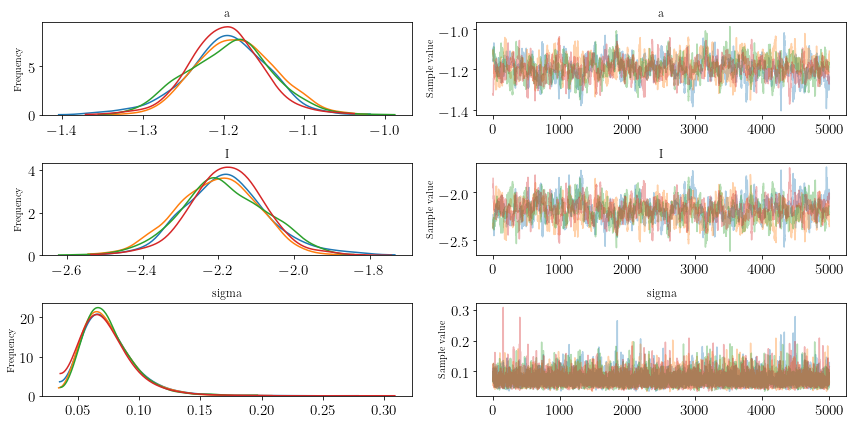

In [8]:
pm.traceplot(trace)
plt.show()

0.006624697039428525 -1.196157265064343


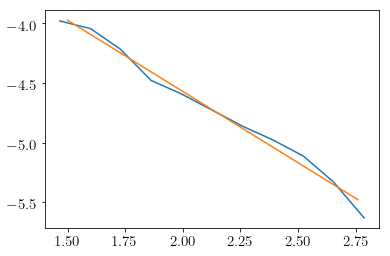

In [9]:
plt.plot(X,Y)
print(10**I_best,a_best)
x = np.linspace(1.5,2.76,100)
plt.plot(x,I_best+a_best*x)

plt.show()

## Total Satellite Sample

dof: 9
[ 0.003 -1.205] [0.    0.034] Chi2_dof=6.77
[ 0.003 -1.246] [0.001 0.036] Chi2_dof=12.44
[ 0.001 -1.107] [0.    0.031] Chi2_dof=3.51


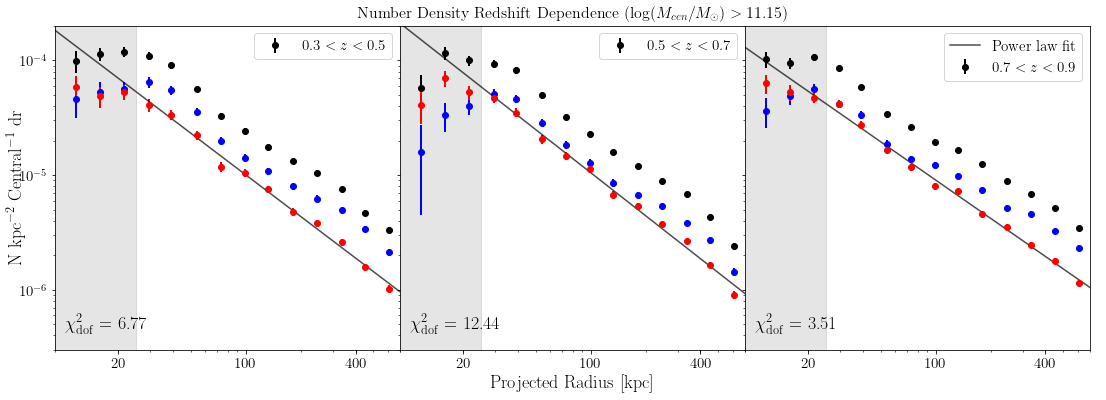

In [383]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

path = 'CUT_deep_catalogs/total_sample/'
csfq = 'all'
count_radial_4 = combine_deep(csfq,'all','9.5','13.0',0.4,path)
count_radial_6 = combine_deep(csfq,'all','9.5','13.0',0.6,path)
count_radial_8 = combine_deep(csfq,'all','9.5','13.0',0.8,path)
count_radial_4_sf = combine_deep(csfq,'ssf','9.5','13.0',0.4,path)
count_radial_6_sf = combine_deep(csfq,'ssf','9.5','13.0',0.6,path)
count_radial_8_sf = combine_deep(csfq,'ssf','9.5','13.0',0.8,path)
count_radial_4_q = combine_deep(csfq,'sq','9.5','13.0',0.4,path)
count_radial_6_q = combine_deep(csfq,'sq','9.5','13.0',0.6,path)
count_radial_8_q = combine_deep(csfq,'sq','9.5','13.0',0.8,path)

bin_edges = np.load(path+'bin_centers.npy')
axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)
axs[0].errorbar(bin_edges, count_radial_4_sf[0],count_radial_4_sf[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6_sf[0],count_radial_6_sf[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8_sf[0],count_radial_8_sf[1],fmt='ob',linewidth=2)
axs[0].errorbar(bin_edges, count_radial_4_q[0],count_radial_4_q[1],fmt='or',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6_q[0],count_radial_6_q[1],fmt='or',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8_q[0],count_radial_8_q[1],fmt='or',linewidth=2)


axs[0].set_yscale('log')
axs[0].set_xscale('log')

#=========
fit_x = np.linspace(2,700,num=100)
start = 4
# Power Law Fitting
# print('fitting power law')
model = 'Power'

popt4,pcov4,chi2_4 = fit_power(bin_edges,count_radial_4_q[0],count_radial_4_q[1], start)
popt6,pcov6,chi2_6 = fit_power(bin_edges,count_radial_6_q[0],count_radial_6_q[1], start)
popt8,pcov8,chi2_8 = fit_power(bin_edges,count_radial_8_q[0],count_radial_8_q[1], start)
perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))

axs[0].plot(fit_x,power_law(fit_x, popt4[0],popt4[1]),'k',alpha=0.7)
axs[1].plot(fit_x,power_law(fit_x, popt6[0],popt6[1]),'k',alpha=0.7)
axs[2].plot(fit_x,power_law(fit_x, popt8[0],popt8[1]),'k',alpha=0.7,label='Power law fit')

# NFW Fitting
# print('fitting NFW')
# model = 'NFW'
# popt4,pcov4,chi2_4 = fit_nfw(bin_edges,count_radial_4[0],count_radial_4[1], start)
# popt6,pcov6,chi2_6 = fit_nfw(bin_edges,count_radial_6[0],count_radial_6[1], start)
# popt8,pcov8,chi2_8 = fit_nfw(bin_edges,count_radial_8[0],count_radial_8[1], start)

# axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),'k',alpha=0.5)
# axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),'k',alpha=0.5)
# axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),'k',alpha=0.5,label='NFW fit')

# NFW + Sersic Fitting
# print('fitting NFW+Sersic')
# model = 'NFW_Sersic'
# popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
# popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
# popt8,pcov8,chi2_8 = fit_nfw_sersic(bin_edges,count_radial_8[0],count_radial_8[1], start)

# axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
# axs[1].plot(fit_x,nfw_sersic(fit_x, popt6[0],popt6[1],popt6[2],popt6[3],popt6[4]),'k',alpha=0.7)
# axs[2].plot(fit_x,nfw_sersic(fit_x, popt8[0],popt8[1],popt8[2],popt8[3],popt8[4]),'k',alpha=0.7,label='NFW+Sersic fit')

# axs[0].plot(fit_x,sersic(fit_x, popt4[2],popt4[3],popt4[4]),'--k',alpha=0.5)
# axs[1].plot(fit_x,sersic(fit_x, popt6[2],popt6[3],popt6[4]),'--k',alpha=0.5)
# axs[2].plot(fit_x,sersic(fit_x, popt8[2],popt8[3],popt8[4]),'--k',alpha=0.5,label='Sersic comp.')

# axs[0].plot(fit_x,nfw(fit_x,popt4[0],popt4[1]),':k',alpha=0.5)
# axs[1].plot(fit_x,nfw(fit_x,popt6[0],popt6[1]),':k',alpha=0.5)
# axs[2].plot(fit_x,nfw(fit_x,popt8[0],popt8[1]),':k',alpha=0.5,label='NFW comp.')
 
np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))
axs[0].annotate('$\chi^2_\mathrm{dof}$ = '+str(round(chi2_4/dof,2)),xy=([0.03,0.05]),xycoords='axes fraction',fontsize=18)
axs[1].annotate('$\chi^2_\mathrm{dof}$ = '+str(round(chi2_6/dof,2)),xy=([0.03,0.05]),xycoords='axes fraction',fontsize=18)
axs[2].annotate('$\chi^2_\mathrm{dof}$ = '+str(round(chi2_8/dof,2)),xy=([0.03,0.05]),xycoords='axes fraction',fontsize=18)


#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([3e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.title('Number Density Redshift Dependence ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/number_density_zdependence_'+model+'.png',dpi=150)
plt.show() 

Total Satellite Sample: mass density profile

## Split for Satellite Mass

In [231]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

# move value<=0 to 1e-10 to avoid bad behavior from plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

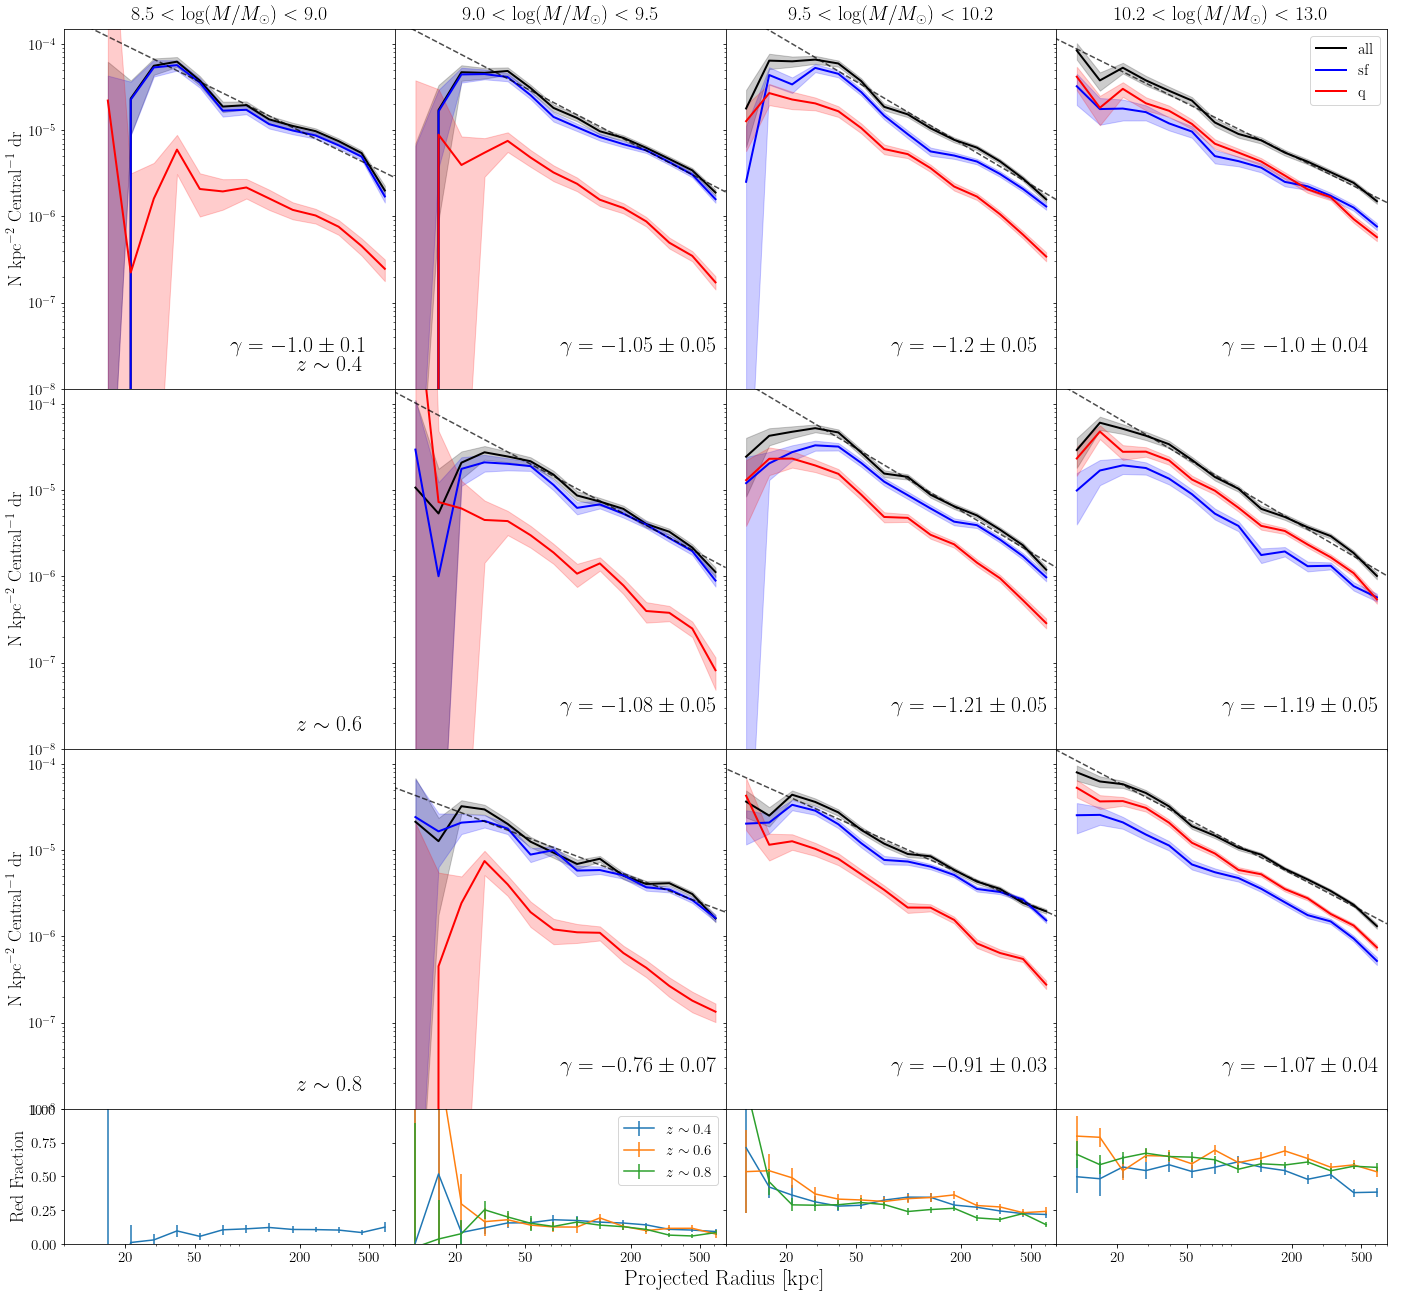

In [301]:
path_old = 'CUT_deep_catalogs/split_sat_mass_new/'
path = 'CUT_deep_catalogs/split_sat_mass_newer/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead

fig, axs = plt.subplots(4, 4, sharex=True, sharey='row', figsize = (20, 18.5),
                        gridspec_kw={'height_ratios':[4,4,4,1.5]})

bin_centers = np.load(path+'bin_centers.npy')
for i in range(3):
    z = i*0.2 + 0.4
    axs[i][0].annotate('$z\sim'+str(round(z,1))+'$',xy=(0.7,0.05),xycoords='axes fraction',fontsize=22)
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [8.5,9.0,9.5,10.2,13.0]
    for j in range(4):
        if i==0 and j==0:
            axs[0][j].set_title('$8.5<\log(M/M_\odot)<9.0$',fontsize=20)
            radial_all = combine_deep('all','all','8.5','9.0', 0.3, path=path_old) 
            radial_sf = combine_deep('all','ssf','8.5','9.0', 0.3, path=path_old)
            radial_q = combine_deep('all','sq','8.5','9.0', 0.3, path=path_old)
        elif j==0:
            continue
        else:
            axs[0][j].set_title('$'+str(mass_range[j])+'<\log(M/M_\odot)<'+str(mass_range[j+1])+'$',fontsize=20)
            radial_all = combine_deep('all','all',str(mass_range[j]),str(mass_range[j+1]), z, path=path) 
            radial_sf = combine_deep('all','ssf',str(mass_range[j]),str(mass_range[j+1]), z, path=path)
            radial_q = combine_deep('all','sq',str(mass_range[j]),str(mass_range[j+1]), z, path=path)
        
        fit_x = np.linspace(2,700,num=100)
        popt,pcov,chi2 = fit_power(bin_centers,radial_all[0],radial_all[1], start=5)
        perr = np.sqrt(np.diag(pcov))
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        axs[i][j].plot(bin_centers, radial_all[0],color='k',linewidth=2,label='all')
        axs[i][j].fill_between(bin_centers,radial_all[0]+radial_all[1],
                               aa(radial_all[0]-radial_all[1]), alpha=0.2, color='k')
        
        axs[i][j].plot(bin_centers, radial_sf[0],color='b',linewidth=2,label='sf')
        axs[i][j].fill_between(bin_centers,radial_sf[0]+radial_sf[1],
                               aa(radial_sf[0]-radial_sf[1]), alpha=0.2, color='b')
        
        axs[i][j].plot(bin_centers, radial_q[0],color='r',linewidth=2,label='q')
        axs[i][j].fill_between(bin_centers,radial_q[0]+radial_q[1],
                               aa(radial_q[0]-radial_q[1]), alpha=0.2, color='r')
        
        axs[i][j].plot(fit_x,power_law(fit_x, popt[0],popt[1]),'--k',alpha=0.7)
        axs[i][j].annotate('$\gamma='+str(round(popt[1],2))+'\pm'+str(round(perr[1],2))+'$',
                           xy=(0.5,0.1),xycoords='axes fraction',fontsize=22)
        
        axs[3][j].errorbar(bin_edges, red_frac,yerr=red_err,label='$z\sim'+str(round(z,1))+'$')

#=============================
axs[0][0].set_ylim([1e-8,1.5e-4])
axs[0][0].set_xlim([9,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')

axs[1][0].set_ylim([1e-8,1.5e-4])
axs[1][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[2][0].set_ylim([1e-8,1.5e-4])
axs[2][0].set_yscale('log')
axs[2][0].set_xscale('log')

axs[3][0].set_ylim([0,1])
axs[0][0].set_xticks([20, 50, 200, 500])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[3][0].set_ylabel('Red Fraction',fontsize=18)
axs[0][3].legend(fontsize=15)
axs[3][1].legend(fontsize=15)
        
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=22)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_mass_redfraction.png')
plt.show()

## Galaxy Conformity

[0.378 0.127 0.271 0.372 0.218 0.256 0.205 0.439 0.362 0.356 0.239 0.245
 0.259 0.243]
sf 0.257 0.024
q 0.342 0.013


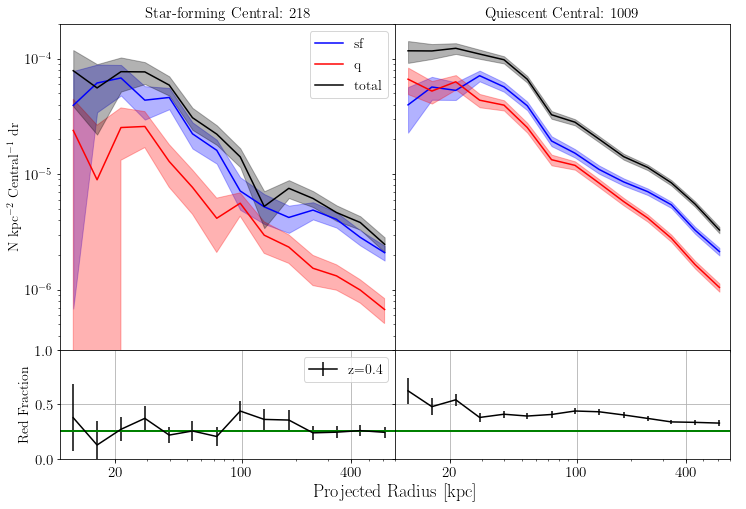

In [378]:
fig, axs = plt.subplots(2, 2, sharex=True,sharey='row', figsize=(12, 8),gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)


path = 'CUT_deep_catalogs/conformity_sfProb/'
z = 0.4
radial_csf_ssf_6 = combine_deep('csf','ssf','9.5','inf',z, path)
radial_csf_sq_6 = combine_deep('csf','sq','9.5','inf',z, path)
radial_csf_6 = combine_deep('csf','all','9.5','inf',z, path)

radial_cq_ssf_6 = combine_deep('cq','ssf','9.5','inf',z, path)
radial_cq_sq_6 = combine_deep('cq','sq','9.5','inf',z, path)
radial_cq_6 = combine_deep('cq','all','9.5','inf',z, path)

redfrac_err_csf_6 = red_frac_err(radial_csf_sq_6[0],radial_csf_ssf_6[0],radial_csf_sq_6[1],radial_csf_ssf_6[1])
redfrac_err_cq_6 = red_frac_err(radial_cq_sq_6[0],radial_cq_ssf_6[0],radial_cq_sq_6[1],radial_cq_ssf_6[1])

bin_centers = np.load(path+'bin_centers.npy')

axs[0][0].errorbar(bin_centers, radial_csf_ssf_6[0], fmt='b',label='sf')
axs[0][0].errorbar(bin_centers, radial_csf_sq_6[0], fmt='r',label='q')
axs[0][0].errorbar(bin_centers, radial_csf_6[0], yerr=None, fmt='k',label='total')
axs[0][0].fill_between(bin_centers,radial_csf_ssf_6[0]+radial_csf_ssf_6[1], 
                       radial_csf_ssf_6[0]-radial_csf_ssf_6[1], alpha=0.3,color='b')
axs[0][0].fill_between(bin_centers,radial_csf_sq_6[0]+radial_csf_sq_6[1], 
                       radial_csf_sq_6[0]-radial_csf_sq_6[1], alpha=0.3,color='r')
axs[0][0].fill_between(bin_centers,radial_csf_6[0]+radial_csf_6[1], 
                       radial_csf_6[0]-radial_csf_6[1], alpha=0.3,color='k')

axs[0][0].legend(fontsize=14)
axs[0][1].errorbar(bin_centers, radial_cq_ssf_6[0], yerr=None, fmt='b')
axs[0][1].errorbar(bin_centers, radial_cq_sq_6[0], yerr=None, fmt='r')
axs[0][1].errorbar(bin_centers, radial_cq_6[0], yerr=None, fmt='k')
axs[0][1].fill_between(bin_centers,radial_cq_ssf_6[0]+radial_cq_ssf_6[1], 
                       radial_cq_ssf_6[0]-radial_cq_ssf_6[1], alpha=0.3,color='b')
axs[0][1].fill_between(bin_centers,radial_cq_sq_6[0]+radial_cq_sq_6[1], 
                       radial_cq_sq_6[0]-radial_cq_sq_6[1], alpha=0.3,color='r')
axs[0][1].fill_between(bin_centers,radial_cq_6[0]+radial_cq_6[1], 
                       radial_cq_6[0]-radial_cq_6[1], alpha=0.3,color='k')


axs[0][0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=14)
axs[0][0].set_title('Star-forming Central: '+str(radial_csf_6[2]),fontsize=15)
axs[0][1].set_title('Quiescent Central: '+str(radial_cq_6[2]),fontsize=15)

red_frac_sf = radial_csf_sq_6[0]/(radial_csf_sq_6[0]+radial_csf_ssf_6[0])
red_frac_q = radial_cq_sq_6[0]/(radial_cq_sq_6[0]+radial_cq_ssf_6[0])
np.set_printoptions(precision=3)
print(red_frac_sf)
print('sf',round(np.average(red_frac_sf[2:],weights=areas[2:]),3),round(np.sqrt(sum(redfrac_err_csf_6[2:]**2))/len(redfrac_err_csf_6[2:]**2),3))
print('q',round(np.average(red_frac_q,weights=areas),3),round(np.sqrt(sum(redfrac_err_cq_6**2))/len(redfrac_err_cq_6**2),3))

axs[1][0].errorbar(bin_centers, red_frac_sf, fmt='k',yerr=redfrac_err_csf_6,label='z='+str(z))
axs[1][1].errorbar(bin_centers, red_frac_q, fmt='k',yerr=redfrac_err_cq_6)

q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(z*10%2)-1]

axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][0].set_ylabel('Red Fraction',fontsize=14)

axs[1][0].legend(fontsize=14)
axs[1][0].set_ylabel('Red Fraction', fontsize=14)

# popt_csf = fit_nfw_sersic(bin_edges,radial_csf_6[0],radial_csf_6[1])
# popt_cq = fit_nfw_sersic(bin_edges,radial_cq_6[0],radial_cq_6[1])


# axs[0][0].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_csf[0],popt_csf[1],popt_csf[2],popt_csf[3])
#                ,'--k',alpha=0.7,label='NFW fit')
# axs[0][1].plot(np.linspace(10,500,num=100),
#          nfw_sersic(np.linspace(10,500,num=100),popt_cq[0],popt_cq[1],popt_cq[2],popt_cq[3]),'--k',alpha=0.7,label='NFW fit')

axs[0][0].set_xlim([10,700])
axs[0][0].set_ylim([3e-7,2e-4])
axs[1][0].set_ylim([0,1])
axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log') 
axs[0][0].set_xticks([20, 100, 400])
axs[0][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[1][0].grid(True)
axs[1][1].grid(True)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.savefig('figures/splitting_central_sfq_'+str(z)+'.png')
plt.show()

KS-test: 0.26086956521739135 0.35991078269860205


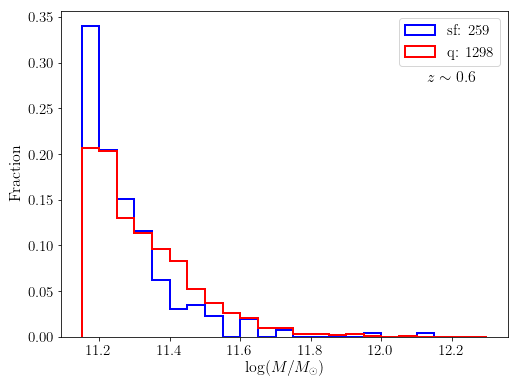

In [287]:
from scipy.stats import ks_2samp
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

sf_mass_list = np.array([])
q_mass_list = np.array([])
for cat_name in ['COSMOS_deep','ELAIS_deep','DEEP_deep','XMM-LSS_deep','SXDS_uddd']:
    cat = Table.read('CUT_deep_catalogs/massive_gal_positions/isolated_'+cat_name+'_11.15_0.6.positions.fits')
    cat_sf = cat[cat['sfprob']>0.4]
    cat_q = cat[cat['sfprob']<0.4]
    sf_mass_list = np.append(sf_mass_list,cat_sf['mass']) 
    q_mass_list = np.append(q_mass_list,cat_q['mass'])
    
weights_sf = np.ones_like(sf_mass_list)/float(len(sf_mass_list))
weights_q = np.ones_like(q_mass_list)/float(len(q_mass_list))

n_sf, bin_edges, pathces = plt.hist(sf_mass_list, weights=weights_sf,bins=np.arange(11.15,12.35,0.05),\
         histtype='step',linewidth=2, color='b',label='sf: '+str(len(sf_mass_list)))
n_q, bin_edges, pathces = plt.hist(q_mass_list, weights=weights_q,bins=np.arange(11.15,12.35,0.05),\
         histtype='step',linewidth=2, color='r',label='q: '+str(len(q_mass_list)))

D,p_value = ks_2samp(n_sf, n_q)
print('KS-test:',D,p_value)

plt.ylabel('Fraction',fontsize=16)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=16)
plt.annotate(r'$z\sim0.6$',xy=(0.82,0.78),xycoords='axes fraction',fontsize=16)
plt.legend(fontsize=15)
plt.savefig('figures/central_11.15_hist.png')
plt.show()

## Link Through Redshift

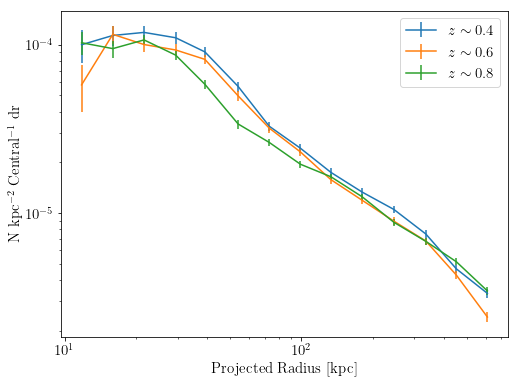

In [341]:
# combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path)

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

path = 'CUT_deep_catalogs/total_sample/'
# radial_2 = combine_deep('all','all','9.5','inf',0.2, path)
radial_4 = combine_deep('all','all','9.5','inf',0.4, path)
radial_6 = combine_deep('all','all','9.5','inf',0.6, path)
radial_8 = combine_deep('all','all','9.5','inf',0.8, path)
bin_centers = np.load(path+'bin_centers.npy')

# plt.errorbar(bin_centers, radial_2[0],yerr=radial_2[1],label='$z\sim0.2$')
plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],label='$z\sim0.4$')
plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],label='$z\sim0.6$')
plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],label='$z\sim0.8$')
plt.axhline(2e-5,10,700,linewidth=4, color='r')

plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')

plt.savefig('figures/radial_evolution.png')
plt.show()

## Host Mass Dependence

In [83]:
def combine_deep_new(masscut_h_low,z,csfq, ssfq):
    path = 'CUT_deep_catalogs/test_host_mass/'
    affix = '_host_'+str(masscut_h_low)+'_9.5_'+csfq+'_'+ssfq+'_'+str(z)+'.txt'
    cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
    sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
    elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
    xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
    deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial,radial_err)

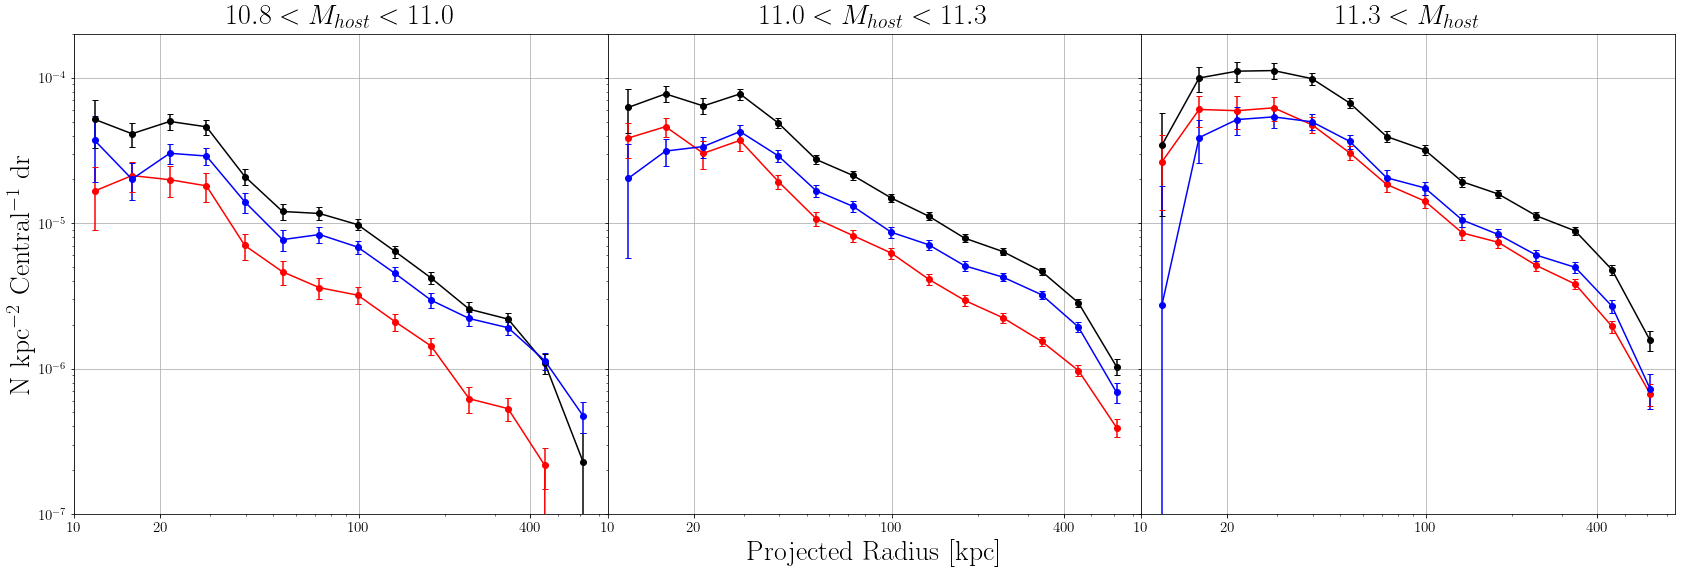

In [74]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24,8))

bin_centers = np.load('CUT_deep_catalogs/split_host_mass/bin_centers.npy')
radial_host_lm = combine_deep_new(10.8,0.6,'all','all')
radial_host_mm = combine_deep_new(11.0,0.6,'all','all')
radial_host_hm = combine_deep_new(11.3,0.6,'all','all')

radial_host_lm_sf = combine_deep_new(10.8,0.6,'all','ssf')
radial_host_mm_sf = combine_deep_new(11.0,0.6,'all','ssf')
radial_host_hm_sf = combine_deep_new(11.3,0.6,'all','ssf')

radial_host_lm_q = combine_deep_new(10.8,0.6,'all','sq')
radial_host_mm_q = combine_deep_new(11.0,0.6,'all','sq')
radial_host_hm_q = combine_deep_new(11.3,0.6,'all','sq')

axs[0].errorbar(bin_centers,radial_host_lm[0],yerr=radial_host_lm[1],fmt='-ok',capsize=3)
axs[0].errorbar(bin_centers,radial_host_lm_q[0],yerr=radial_host_lm_q[1],fmt='-or',capsize=3)
axs[0].errorbar(bin_centers,radial_host_lm_sf[0],yerr=radial_host_lm_sf[1],fmt='-ob',capsize=3)

axs[1].errorbar(bin_centers,radial_host_mm[0],yerr=radial_host_mm[1],fmt='-ok',capsize=3)
axs[1].errorbar(bin_centers,radial_host_mm_q[0],yerr=radial_host_mm_q[1],fmt='-or',capsize=3)
axs[1].errorbar(bin_centers,radial_host_mm_sf[0],yerr=radial_host_mm_sf[1],fmt='-ob',capsize=3)

axs[2].errorbar(bin_centers,radial_host_hm[0],yerr=radial_host_hm[1],fmt='-ok',capsize=3)
axs[2].errorbar(bin_centers,radial_host_hm_q[0],yerr=radial_host_hm_q[1],fmt='-or',capsize=3)
axs[2].errorbar(bin_centers,radial_host_hm_sf[0],yerr=radial_host_hm_sf[1],fmt='-ob',capsize=3)

axs[0].set_title(r'$10.8<M_{host}<11.0$',fontsize=28)
axs[1].set_title(r'$11.0<M_{host}<11.3$',fontsize=28)
axs[2].set_title(r'$11.3<M_{host}$',fontsize=28)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim([10,750])
axs[0].set_ylim([1e-7,2e-4])
axs[0].set_ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=28)
axs[0].set_xticks([10, 20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].grid(True,which="major",ls="-")
axs[1].grid(True,which="major",ls="-")
axs[2].grid(True,which="major",ls="-")


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.xlabel('Projected Radius [kpc]', fontsize=28)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/split_host_mass_sfProb.png')
plt.show()